# Benchmark: Area computation

Benchmark comparing area computation across:
* [georust/geo](https://lib.rs/crates/geo) crate
* The [geos C library](https://trac.osgeo.org/geos/), used through high-level Rust bindings via the [geos](https://lib.rs/crates/geos) crate

# Prerequisites

Generate data:

```sh
cd harness
cargo run --bin benchmark_area -- --out-file ../analysis/benchmark_area/data.json  --iterations 1000
```

### Loading data from /mnt/data/source/explore-georust/analysis/benchmark_area/data.json
### Statistics: Raw data
        duration.total_ms             
program               geo         geos
count         1000.000000  1000.000000
mean            23.300793     1.077318
std              2.542489     0.301034
min             22.166855     0.915126
25%             22.753028     0.980982
50%             22.877083     1.024564
75%             23.041987     1.118493
max             65.972860     9.605914


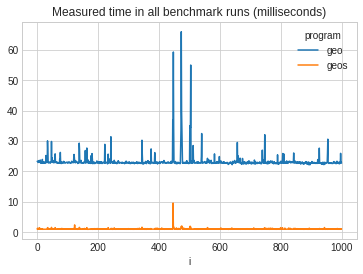

### Statistics: After outlier removal
        duration.total_ms            
program               geo        geos
count          976.000000  976.000000
mean            22.999575    1.058833
std              0.629755    0.099860
min             22.166855    0.915126
25%             22.748016    0.980844
50%             22.871326    1.020764
75%             23.026724    1.116730
max             28.184790    1.620629


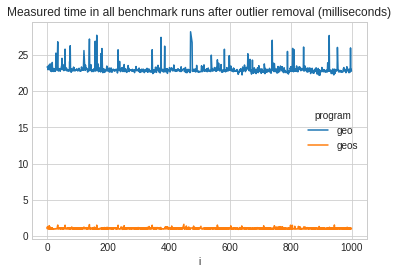

## Absolute difference in runtimes compared to geo
        difference_ms
program          geos
count      976.000000
mean       -21.940742
std          0.627454
min        -27.077941
25%        -22.014231
50%        -21.831699
75%        -21.663283
max        -21.000357


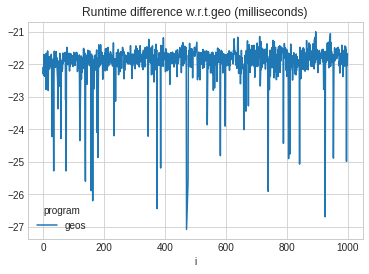

## Relative difference in runtimes compared to geo
        relative_difference
program                geos
count            976.000000
mean              -0.953942
std                0.004333
min               -0.964656
25%               -0.957253
50%               -0.955604
75%               -0.951035
max               -0.929860


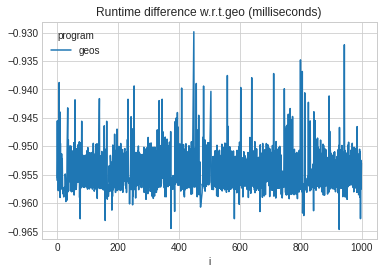

In [5]:
import os
data_absolute_path = os.path.join(os.getcwd(), 'data.json')
%run ../common/benchmark_analysis.ipynb